# **RANS CFD on 2D CRM Airfoil**
This notebook shows how to set up and run a 2D CRM airfoil simulation using Flow360 python API.

>Note: the cost of running the case shown in this notebook is less than 1 FlexCredit.

Geometry for this tutorial was created using Engineering Sketch Pad (ESP) and is already provided.

We will walk through all the steps such as importing modules, creating a project and assigning simulation parameters.

Additionally, we will use the function `fl.operating_condition_from_mach_reynolds()`, which is often utilized when running workshop cases and allows us to define operating conditions using mach and reynolds number.

In order to get a closer look at how we describe each parameter, we will first split the simulation parameters into smaller parts, which will be assembled later on.

As a first step, we will import all dependencies.

In [1]:
# flow360 imports
import flow360 as fl
from flow360.examples import Tutorial2DCRM
from flow360.log import log, set_logging_level

log.log_to_file = False
set_logging_level("INFO")

## Project creation
We then begin by creating a project variable, which will be used to do operations on the geometry as well as running the case, which includes creating surface and volume meshes.

In [2]:
# Download files associated with the tutorial
Tutorial2DCRM.get_files()

# Create project variable
project = fl.Project.from_file(
    files=fl.GeometryFiles(Tutorial2DCRM.geometry), name="Tutorial 2D CRM from Python"
)

# Create geometry variable
geometry = project.geometry

# Show face and edge groupings for the geometry
geometry.show_available_groupings(verbose_mode=True)

geometry.group_faces_by_tag("faceName")
geometry.group_edges_by_tag("edgeName")

Output()

[10:44:50] INFO: Geometry successfully submitted:                                                                  
                   name   = Tutorial 2D CRM from Python                                                            
                   id     = geo-b9974283-e3cf-471a-9504-a328e1892a4a                                               
                   status = uploaded                                                                               
           

           INFO: Waiting for geometry to be processed.

[10:45:18] WARNING: Could not find face grouping info in the draft's simulation settings. Please remember to group 
           them if relevant features are used.

           WARNING: Could not find edge grouping info in the draft's simulation settings. Please remember to group 
           them if relevant features are used.

[10:45:19] INFO:  >> Available attribute tags for grouping **faces**:

           INFO:     >> Tag 0: faceName. Grouping with this tag results in:

           INFO:         >> Group 0: wingTrailing

           INFO:            IDs: ['body0001_face0001']

           INFO:         >> Group 1: wing

           INFO:            IDs: ['body0001_face0002', 'body0001_face0003', 'body0001_face0004',                   
           'body0001_face0005', 'body0001_face0006']

           INFO:         >> Group 2: flapTrailing

           INFO:            IDs: ['body0002_face0001']

           INFO:         >> Group 3: flap

           INFO:            IDs: ['body0002_face0002', 'body0002_face0003', 'body0002_face0004',                   
           'body0002_face0005']

           INFO:         >> Group 4: slatTrailing

           INFO:            IDs: ['body0003_face0001']

           INFO:         >> Group 5: slat

           INFO:            IDs: ['body0003_face0002', 'body0003_face0003', 'body0003_face0004',                   
           'body0003_face0005', 'body0003_face0006', 'body0003_face0007']

           INFO:     >> Tag 1: groupName. Grouping with this tag results in:

           INFO:         >> Group 0: wing

           INFO:            IDs: ['body0001_face0001', 'body0001_face0002', 'body0001_face0003',                   
           'body0001_face0004', 'body0001_face0005', 'body0001_face0006']

           INFO:         >> Group 1: flap

           INFO:            IDs: ['body0002_face0001', 'body0002_face0002', 'body0002_face0003',                   
           'body0002_face0004', 'body0002_face0005']

           INFO:         >> Group 2: slat

           INFO:            IDs: ['body0003_face0001', 'body0003_face0002', 'body0003_face0003',                   
           'body0003_face0004', 'body0003_face0005', 'body0003_face0006', 'body0003_face0007']

           INFO:  >> Available attribute tags for grouping **edges**:

           INFO:     >> Tag 0: edgeName. Grouping with this tag results in:

           INFO:         >> Group 0: wingtrailingEdge

           INFO:            IDs: ['body0001_edge0001', 'body0001_edge0002', 'body0001_edge0008']

           INFO:         >> Group 1: symmetry

           INFO:            IDs: ['body0001_edge0003', 'body0001_edge0004', 'body0001_edge0006',                   
           'body0001_edge0007', 'body0001_edge0009', 'body0001_edge0010', 'body0001_edge0011', 'body0001_edge0012',
           'body0002_edge0003', 'body0002_edge0004', 'body0002_edge0006', 'body0002_edge0007', 'body0002_edge0008',
           'body0002_edge0009', 'body0003_edge0003', 'body0003_edge0004', 'body0003_edge0006', 'body0003_edge0007',
           'body0003_edge0009', 'body0003_edge0010', 'body0003_edge0012', 'body0003_edge0013', 'body0003_edge0014',
           'body0003_edge0015']

           INFO:         >> Group 2: wingleadingEdge

           INFO:            IDs: ['body0001_edge0005']

           INFO:         >> Group 3: flaptrailingEdge

           INFO:            IDs: ['body0002_edge0001', 'body0002_edge0002']

           INFO:         >> Group 4: flapleadingEdge

           INFO:            IDs: ['body0002_edge0005']

           INFO:         >> Group 5: slattrailingEdge

           INFO:            IDs: ['body0003_edge0001', 'body0003_edge0002', 'body0003_edge0005',                   
           'body0003_edge0008']

           INFO:         >> Group 6: slatFrontLEadingEdge

           INFO:            IDs: ['body0003_edge0011']

## Defining simulation parameters
Once the geometry is processed, we can create separate variables for:
- [Entities and volume zones](#Entities-and-volume-zones)
- [Meshing parameters](#Meshing-parameters)
- [Reference geometry](#Reference-geometry)
- [Operating condition](#Operating-condition)
- [Time stepping](#Time-stepping)
- [Models](#Models)
- [Outputs](#Outputs)

A helpful statement we will use is `with fl.SI_unit_system:`, which allows us to automatically assign SI units to parameters. 

We still need to manually define the unit for angle as there is no default angle unit when using `with fl.SI_unit_system:`.

### Entities and volume zones
Cylinder entites are used for creating mesh refinements.

Farfield volume zone is used for defining volume zones and models.

In [3]:
# Choosing a unit system
with fl.SI_unit_system:

    # Cylinder entities used for mesh refinements
    cylinders = [
        fl.Cylinder(
            name=f"cylinder{i+1}",
            axis=[0, 1, 0],
            center=[0.7, 0.5, 0],
            outer_radius=outer_radius,
            height=1.0,
        )
        for i, outer_radius in enumerate([1.1, 2.2, 3.3, 4.5])
    ]
    cylinder5 = fl.Cylinder(
        name="cylinder5", axis=[-1, 0, 0], center=[6.5, 0.5, 0], outer_radius=6.5, height=10
    )

    # Farfield used for creating a volume zone and assigning appropriate models
    farfield = fl.AutomatedFarfield(name="farfield", method="quasi-3d")

           INFO: using: SI unit system for unit inference.

### Meshing parameters
In this section we will assign settings so that our mesh will have sufficient level of refinement for this case.

Default settings describe how the the mesh will be created globally, while refinements allow for much more precise control of the mesh in regions of interest.

Here we will utilize the previously created cylinder entities, farfield, and we will also refer to geometry's faces and edges, which were grouped in the [Project creation](#Project-creation) step.

In [4]:
with fl.SI_unit_system:
    meshing_params = fl.SimulationParams(
        meshing=fl.MeshingParams(
            # Default settings for meshing
            defaults=fl.MeshingDefaults(
                surface_edge_growth_rate=1.17,
                surface_max_edge_length=1.1,
                curvature_resolution_angle=12 * fl.u.deg,
                boundary_layer_growth_rate=1.17,
                boundary_layer_first_layer_thickness=1.8487111e-06,
            ),
            # Adjust all spacings in refinement regions
            refinement_factor=1.35,
            # Adjust narrow gap treatment strength for two surfaces in close proximity
            gap_treatment_strength=0.5,
            # Crete new volume zones
            volume_zones=[farfield],
            # Additional fine-tunning for refinements on top of defaults
            refinements=[
                # Uniform spacing refinement inside specified region of mesh
                fl.UniformRefinement(name="refinement1", spacing=0.1, entities=[cylinders[0]]),
                fl.UniformRefinement(name="refinement2", spacing=0.15, entities=[cylinders[1]]),
                fl.UniformRefinement(name="refinement3", spacing=0.225, entities=[cylinders[2]]),
                fl.UniformRefinement(name="refinement4", spacing=0.275, entities=[cylinders[3]]),
                fl.UniformRefinement(name="refinement5", spacing=0.325, entities=[cylinder5]),
                # Refine surface elements for given faces
                fl.SurfaceRefinement(name="wing", max_edge_length=0.74, faces=[geometry["wing"]]),
                fl.SurfaceRefinement(
                    name="flap-slat",
                    max_edge_length=0.55,
                    faces=[geometry["flap"], geometry["slat"]],
                ),
                fl.SurfaceRefinement(
                    name="trailing",
                    max_edge_length=0.36,
                    faces=[
                        # '*' allows us to select all faces faces ending with 'Trailing'
                        geometry["*Trailing"],
                    ],
                ),
                # Grows anisotropic layers orthogonal to the specified edges
                fl.SurfaceEdgeRefinement(
                    name="edges",
                    method=fl.HeightBasedRefinement(value=0.0007),
                    edges=[
                        # Similarly as above, we can select multiple edges using '*' expression
                        geometry["*trailingEdge"],
                        geometry["*leadingEdge"],
                    ],
                ),
                fl.SurfaceEdgeRefinement(
                    name="symmetry", method=fl.ProjectAnisoSpacing(), edges=[geometry["symmetry"]]
                ),
            ],
        ),
    )

           INFO: using: SI unit system for unit inference.

### Reference geometry
Now we will define the `reference_geometry` which is used to report forces such as drag and lift.

In [5]:
with fl.SI_unit_system:
    reference_geometry_params = fl.SimulationParams(
        # Create geometrical related reference values
        reference_geometry=fl.ReferenceGeometry(
            moment_center=[0.25, 0, 0], moment_length=[1, 1, 1], area=0.01
        )
    )

[10:45:20] INFO: using: SI unit system for unit inference.

### Operating condition
Next up is the definition of flow conditions with the help of `fl.operating_condition_from_mach_reynolds()` function, which does not require knowledge of air properties in desired conditions and instead allows the usage of mach number in conjunction with reynolds number. This is particularly useful for conducting workshop cases as we can easily simulate flow conditions for different values of reynolds number. Viscosity as well as density are going to be automatically calculated based on input parameters.

In [6]:
with fl.SI_unit_system:
    operating_condition_params = fl.SimulationParams(
        # Create operating conditions using mach and reynolds number
        operating_condition=fl.operating_condition_from_mach_reynolds(
            mach=0.2,
            reynolds=5e6,
            temperature=272.1,
            alpha=16 * fl.u.deg,
            beta=0 * fl.u.deg,
            project_length_unit=1 * fl.u.m,
        ),
    )

           INFO: using: SI unit system for unit inference.

           INFO: Density and viscosity were calculated based on input data, ThermalState will be automatically     
           created.

### Time stepping
Even though our simulation will be run as a Steady State case, the solver will use information about time stepping, so we define it accordingly.

`max_steps` is the maximum amount of psuedo time steps in one physical step, which can be interpreted as the maximum number of iterations.

CFL is the Courant–Friedrichs–Lewy condition and `RampCFL` specifies its initial and final value, as well as the amount of pseudo time steps before achieving the final value.

In [7]:
with fl.SI_unit_system:
    time_stepping_params = fl.SimulationParams(
        # Time stepping settings for Steady State simulation
        time_stepping=fl.Steady(
            max_steps=3000, CFL=fl.RampCFL(initial=20, final=300, ramp_steps=500)
        ),
    )

           INFO: using: SI unit system for unit inference.

### Models
This parameter is used to define solver settings, numerical models and boundary conditions within our simulation.

In [8]:
with fl.SI_unit_system:
    models_params = fl.SimulationParams(
        # Solver settings, numerical models and boundary conditions
        models=[
            # Create wall boundary condition
            fl.Wall(
                surfaces=[
                    # Here we use '*' to select all surfaces
                    geometry["*"],
                ],
                name="wall",
            ),
            # Create freestream boundary condition
            fl.Freestream(surfaces=farfield.farfield, name="Freestream"),
            # Create slip wall boundary condition
            fl.SlipWall(surfaces=farfield.symmetry_planes, name="slipwall"),
            # Create fluid volume model
            fl.Fluid(
                # Set up compressible Navier-Stokes solver
                navier_stokes_solver=fl.NavierStokesSolver(
                    absolute_tolerance=1e-11,
                    linear_solver=fl.LinearSolver(max_iterations=35),
                    kappa_MUSCL=0.33,
                ),
                # Set up turbulence solver based on the Spalart-Allmaras model
                turbulence_model_solver=fl.SpalartAllmaras(
                    absolute_tolerance=1e-10,
                    linear_solver=fl.LinearSolver(max_iterations=25),
                    equation_evaluation_frequency=1,
                ),
            ),
        ],
    )

           INFO: using: SI unit system for unit inference.

### Outputs
Here we will specify which outputs we want Flow360 to produce for us.

In [9]:
with fl.SI_unit_system:
    outputs_params = fl.SimulationParams(
        outputs=[
            # Specify the list of volume output variables
            fl.VolumeOutput(
                name="fl.VolumeOutput",
                output_fields=[
                    "primitiveVars",
                    "vorticity",
                    "residualNavierStokes",
                    "residualTurbulence",
                    "Cp",
                    "Mach",
                    "qcriterion",
                    "mut",
                ],
            ),
            # Specify the list of surface output variables
            fl.SurfaceOutput(
                name="fl.SurfaceOutput",
                surfaces=geometry["*"],
                output_fields=[
                    "primitiveVars",
                    "Cp",
                    "Cf",
                    "CfVec",
                    "yPlus",
                ],
            ),
        ],
    )

           INFO: using: SI unit system for unit inference.

### Combining parameters
After we created multiple instances of `SimulationParams` class, we can create one final instace, which will contain all of the parameters defined by us previously.
Flow360 allows us to refer to each parameter specified within `SimulationParams`, for example using `meshing_params.meshing`, we can access meshing parameters within that variable.

In [10]:
with fl.SI_unit_system:
    params = fl.SimulationParams(
        meshing=meshing_params.meshing,
        reference_geometry=reference_geometry_params.reference_geometry,
        operating_condition=operating_condition_params.operating_condition,
        time_stepping=time_stepping_params.time_stepping,
        models=models_params.models,
        outputs=outputs_params.outputs,
    )

           INFO: using: SI unit system for unit inference.

## Running the case
With all of our parameters defined, we can pass them to our project and run the case.

In [11]:
case = project.run_case(params=params, name="Case of tutorial 2D CRM from Python")

To view the project tree with all of its meshes and cases, use:

In [12]:
project.print_project_tree()

┌──────────────────────────────┐ ┌──────────────────────────────┐ ┌──────────────────────────────┐ ┌──────────────────────────────┐
│         <<Geometry>>         │ │       <<SurfaceMesh>>        │ │        <<VolumeMesh>>        │ │           <<Case>>           │
│name: Tutorial 2D CRM from    │ │name: Case of tutorial 2D CRM │ │name: Case of tutorial 2D CRM │ │name: Case of tutorial 2D CRM │
│Python                        │─│from Python                   │─│from Python                   │─│from Python                   │
│id:   geo-b997428             │ │id:   sm-27f3e8a              │ │id:   vm-7b678d3              │ │id:   case-78e8a8e            │
└──────────────────────────────┘ └──────────────────────────────┘ └──────────────────────────────┘ └──────────────────────────────┘


>Note: case can also be assigned using the case-id, which for example can be taken from the project tree.

`case = project.get_case(asset_id="case-XXXXXXX")`

## Post processing
After we have successfully run the simulation, we can post process our results.

We will do so by first, downloading the results of interest from the server.

To do that we will use a variable containing information about the case. 
>Note: we will use the `wait()` method, which will wait with the execution of the rest of the code until the case has finished running.

In [13]:
case.wait()

Next we can download the results.
We will be looking at the post processing of these quantities:
- total forces
- nonlinear residuals
- CFL
- total CD along the X axis

In [14]:
total_forces = case.results.total_forces
total_forces = total_forces.as_dataframe()

nonlinear_residuals = case.results.nonlinear_residuals
nonlinear_residuals = nonlinear_residuals.as_dataframe()

cfl = case.results.cfl
cfl = cfl.as_dataframe()

x_slicing_force_distribution = case.results.x_slicing_force_distribution
x_slicing_force_distribution.wait()
x_slicing_force_distribution = x_slicing_force_distribution.as_dataframe()

Output()

[11:07:53] INFO: Saved to                                                                                          
           /var/folders/qk/mywsrvps5gl_f3yjx2k1v1xm0000gn/T/tmpvyt05078/8d455ed5-c6ca-4358-8104-05a56887745a.csv

Output()

[11:07:54] INFO: Saved to                                                                                          
           /var/folders/qk/mywsrvps5gl_f3yjx2k1v1xm0000gn/T/tmpvyt05078/848840ff-62ab-40ec-9283-146ea12bc800.csv

Output()

[11:07:56] INFO: Saved to                                                                                          
           /var/folders/qk/mywsrvps5gl_f3yjx2k1v1xm0000gn/T/tmpvyt05078/119f7ebb-aefc-49a9-b7cb-19d9bc2eb77e.csv

Output()

[11:07:57] INFO: Saved to                                                                                          
           /var/folders/qk/mywsrvps5gl_f3yjx2k1v1xm0000gn/T/tmpvyt05078/475de77b-a3c1-4bbf-a5fb-19269bf70cfa.csv

In order to obtain the X and Y variable names for our plots, we will print out the dataframe columns and look at their names.

In [15]:
print(cfl.columns)

Index(['physical_step', 'pseudo_step', '0_NavierStokes_cfl',
       '1_SpalartAllmaras_cfl'],
      dtype='object')


>Note: The same can be done for all of the downloaded results.

First, we will look at how the residuals change as the pseudo step progresses.

<Axes: xlabel='Pseudo Step', ylabel='residuals'>

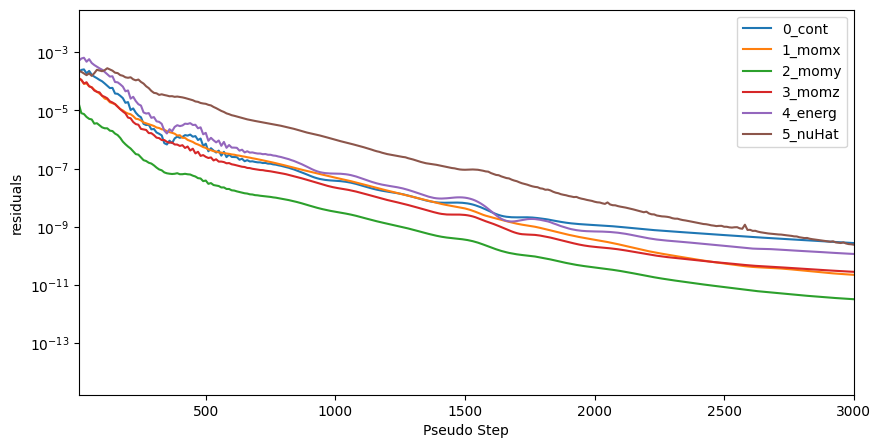

In [16]:
nonlinear_residuals.plot(
    x="pseudo_step",
    y=["0_cont", "1_momx", "2_momy", "3_momz", "4_energ", "5_nuHat"],
    logy=True,
    xlim=(10, 3000),
    xlabel="Pseudo Step",
    ylabel="residuals",
    figsize=(10, 5),
)

Next are the CFL values for both the Navier-Stokes solver, as well as the turbulence model solver with Spalart-Allmaras model selected.

<Axes: xlabel='pseudo_step'>

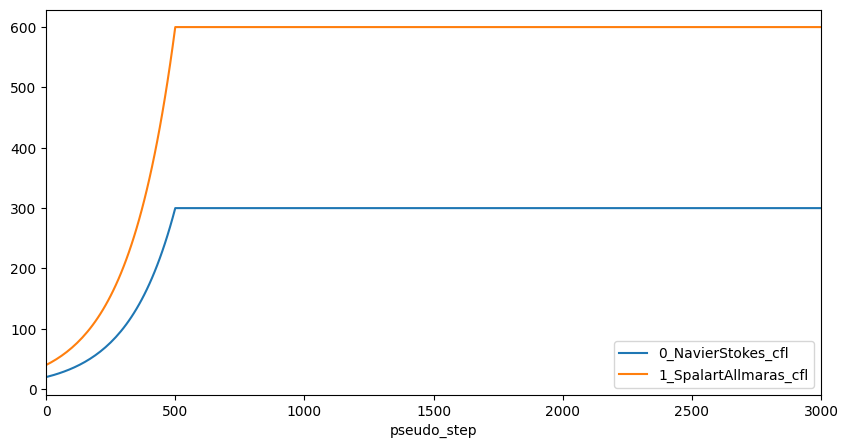

In [17]:
cfl.plot(
    x="pseudo_step",
    y=["0_NavierStokes_cfl", "1_SpalartAllmaras_cfl"],
    xlim=(0, 3000),
    figsize=(10, 5),
)

Another popular form of data visualisation indicating the convergence status of the solution for aerodynamic applications is monitoring how the CL and CD values change with pseudo steps (iterations).

<Axes: xlabel='Pseudo Step', ylabel='CD'>

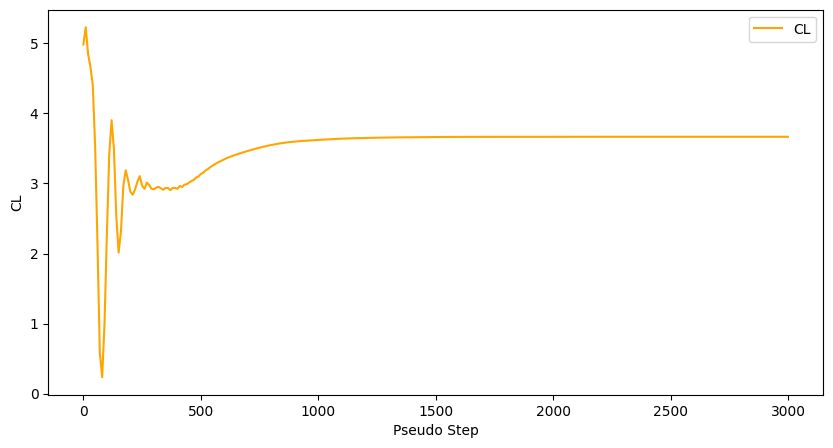

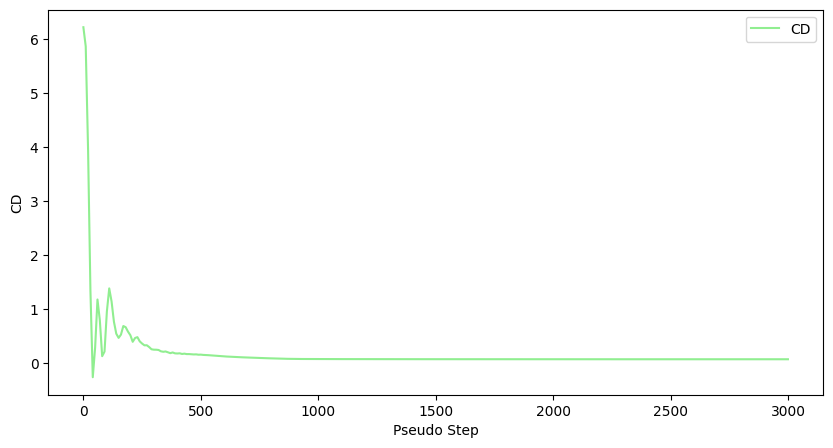

In [18]:
total_forces.plot(
    x="pseudo_step", y="CL", xlabel="Pseudo Step", ylabel="CL", figsize=(10, 5), style="orange"
)
total_forces.plot(
    x="pseudo_step", y="CD", xlabel="Pseudo Step", ylabel="CD", figsize=(10, 5), style="lightgreen"
)

Finally, we will define a graph showcasing how CD varies alongside the X axis.

<Axes: xlabel='X', ylabel='CD'>

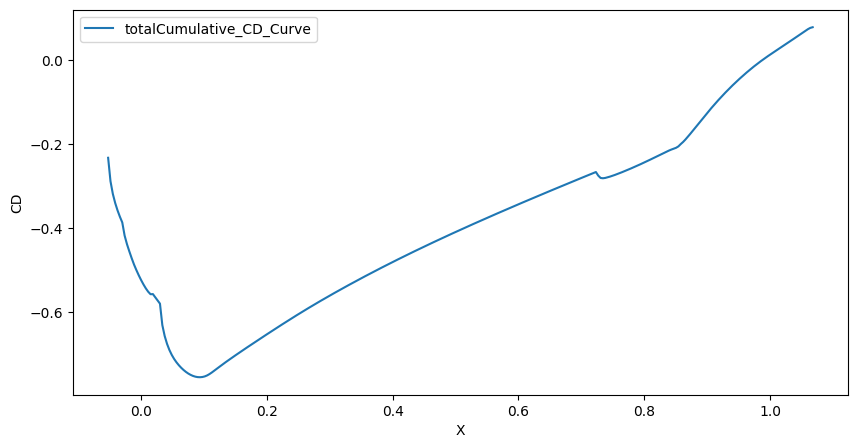

In [19]:
x_slicing_force_distribution.plot(
    x="X", y="totalCumulative_CD_Curve", xlabel="X", ylabel="CD", figsize=(10, 5)
)

More information can be found on the documentation page for this case, available [here](https://docs.flexcompute.com/projects/flow360/en/latest/tutorials/Multielement_Configuration/Multielement_Configuration.html).